# Importing Libraries

In [2]:
import numpy as np
import tensorflow as tf
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")


# Notes
num_samples = 100
image_shape = (64, 64, 3)
quantum_data_shape = (64,)

# Loading and Preprocessing data

In [3]:
# Load and preprocess data from subfolders
def load_data(folder):
    images = []
    labels = []
    class_names = sorted(os.listdir(folder))
    for class_index, class_name in enumerate(class_names):
        class_path = os.path.join(folder, class_name)
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            image = cv2.imread(image_path)
            image = cv2.resize(image, (64,64))
            images.append(image)
            labels.append(class_index)
    return images, labels

# Load and preprocess image data
images, labels = load_data('Retinopath_images\data')

# Split data into train and test sets
train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.2, random_state=42, stratify=labels
)

# Convert lists to numpy arrays
train_images = np.array(train_images)
train_labels = np.array(train_labels)
test_images = np.array(test_images)
test_labels = np.array(test_labels)

# Normalize pixel values to the range [0, 1]
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

# Print shapes for verification
print("Train images shape:", train_images.shape)
print("Train labels shape:", train_labels.shape)
print("Test images shape:", test_images.shape)
print("Test labels shape:", test_labels.shape)

Train images shape: (2929, 64, 64, 3)
Train labels shape: (2929,)
Test images shape: (733, 64, 64, 3)
Test labels shape: (733,)


# Implementing Quantum circuit

In [4]:
import numpy as np
from qiskit import QuantumCircuit, Aer, transpile, assemble


def create_quantum_circuit(image_features):
    num_features = len(image_features)
    quantum_register = QuantumCircuit(num_features, num_features)  # Define quantum and classical registers
    
    # Apply quantum operations to encode image features into quantum states
    for i in range(num_features):
        # Convert array to scalar (taking the mean of pixel values for simplicity)
        value = np.mean(image_features[i])
        
        # Scale the value to a suitable range for quantum gates (e.g., [0, pi])
        scaled_value = value * np.pi / 255.0
        
        # Apply rotation gate based on scaled feature value
        quantum_register.ry(scaled_value, i)
        
    quantum_register.measure_all()
        
    return quantum_register

#  Quantum-assisted deep learning


In [5]:
import numpy as np
from qiskit import QuantumCircuit, Aer, transpile, assemble


def qsdl(set1):
    train_q = set1
    #train_q = set1

    # Create an array to store the measurement outcomes
    num_images = len(train_q)  
    num_qubits = 6  # Number of qubits
    num_outcomes = 2 ** num_qubits  # Possible outcomes for 6 qubits

    quantum_data = np.zeros((num_images, num_outcomes), dtype=int)

    # Simulate each quantum circuit and store measurement outcomes
    simulator = Aer.get_backend('aer_simulator')
    for i, image_features in enumerate(train_q):
        qc = create_quantum_circuit(image_features)
        compiled_circuit = transpile(qc, simulator)
        qobj = assemble(compiled_circuit)
        result = simulator.run(qobj).result()
        counts = result.get_counts()


        for outcome, count in counts.items():
            original_string = outcome
            without_spaces = "".join(original_string.split())
            outcome_int = int(without_spaces, 2)

            if outcome_int < num_outcomes:
                quantum_data[i, outcome_int] = count

    # Print the quantum data array
    print("Quantum data created")
    return quantum_data
    #print(quantum_data)


# Implementing CNN

In [6]:
#X_train_cnn = np.random.rand(num_samples, *image_shape)
#X_train_cnn = np.random.rand(num_samples, *image_shape)


#X_train_quantum = np.random.rand(num_samples, *quantum_data_shape)
#y_train = np.random.randint(2, size=num_samples)


# Define the CNN model
cnn_input = tf.keras.layers.Input(shape=image_shape)
cnn_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(cnn_input)
cnn_flatten = tf.keras.layers.Flatten()(cnn_layer)

# Define the quantum data input
quantum_input = tf.keras.layers.Input(shape=quantum_data_shape)

# Combine CNN and quantum data
combined = tf.keras.layers.Concatenate()([cnn_flatten, quantum_input])

# Fully connected layers
dense1 = tf.keras.layers.Dense(128, activation='relu')(combined)
output = tf.keras.layers.Dense(5, activation='softmax')(dense1)

# Create the model
model = tf.keras.models.Model(inputs=[cnn_input, quantum_input], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 62, 62, 32)           896       ['input_1[0][0]']             
                                                                                                  
 flatten (Flatten)           (None, 123008)               0         ['conv2d[0][0]']              
                                                                                                  
 input_2 (InputLayer)        [(None, 64)]                 0         []                            
                                                                                              

# Fitting or Training the model

In [7]:
# Train the model
quantum_data=qsdl(train_images[:100])
#history=model.fit([train_images, quantum_data], train_labels, epochs=10, batch_size=32)
history=model.fit([train_images[:100], quantum_data[:100]], train_labels[:100], epochs=10, batch_size=32)

C:\Users\Sekhar\AppData\Local\Temp\ipykernel_14616\3171187236.py:22: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  result = simulator.run(qobj).result()


Quantum data created
Epoch 1/10
4/4 [==============================] - 5s 288ms/step - loss: 12.2559 - accuracy: 0.3400
Epoch 2/10
4/4 [==============================] - 1s 272ms/step - loss: 3.2624 - accuracy: 0.4400
Epoch 3/10
4/4 [==============================] - 1s 274ms/step - loss: 2.7252 - accuracy: 0.7300
Epoch 4/10
4/4 [==============================] - 1s 261ms/step - loss: 2.3273 - accuracy: 0.7200
Epoch 5/10
4/4 [==============================] - 1s 259ms/step - loss: 1.8486 - accuracy: 0.7000
Epoch 6/10
4/4 [==============================] - 1s 264ms/step - loss: 1.1381 - accuracy: 0.7500
Epoch 7/10
4/4 [==============================] - 1s 264ms/step - loss: 0.7091 - accuracy: 0.7400
Epoch 8/10
4/4 [==============================] - 1s 264ms/step - loss: 0.7308 - accuracy: 0.7800
Epoch 9/10
4/4 [==============================] - 1s 267ms/step - loss: 0.6852 - accuracy: 0.8100
Epoch 10/10
4/4 [==============================] - 1s 261ms/step - loss: 0.5991 - accuracy: 0.84

# Visualization

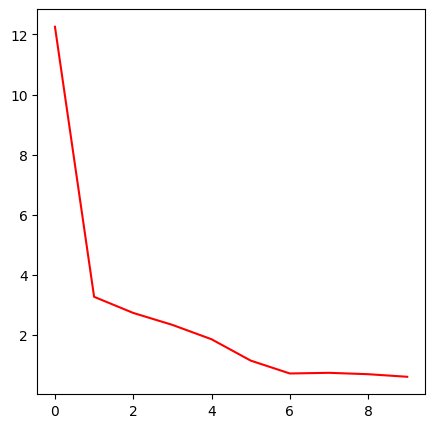

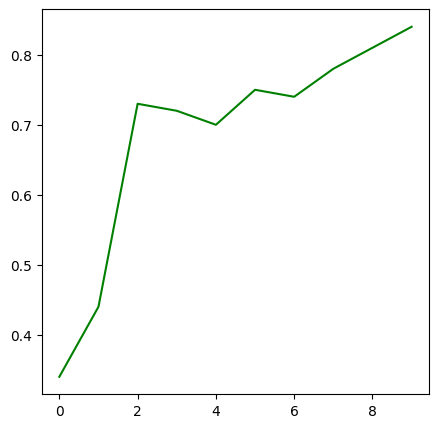

In [8]:
info=history.history 
info

#LOSS VIZULATIZATION
plt.figure(figsize=(5,5))
plt.plot(info['loss'],color="red",label="loss")
plt.show()

#ACCURACY VIZULIZATION
plt.figure(figsize=(5,5))
plt.plot(info['accuracy'],color="green",label="loss")

plt.show()

# quantum_data_for_test_images

In [9]:
#call qsdl
quantum_data_test=qsdl(test_images[:100])

C:\Users\Sekhar\AppData\Local\Temp\ipykernel_14616\3171187236.py:22: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  result = simulator.run(qobj).result()


Quantum data created


# metrics evalution  over predictions made by test data

In [16]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score


predictions = model.predict([test_images[:100], quantum_data_test[:100]])

predicted_labels = np.argmax(predictions, axis=1)

print(predicted_labels) 

#printing classes

Actual={0:"Mild",1:"Moderate",2:"No_DR",3:"Proliferate_DR",4:"Severe"}

for i in predicted_labels:
    print("The class of the image is -->",Actual[i])
    

# Calculate precision, recall, F1 score, and accuracy
precision = precision_score(train_labels[:100], predicted_labels, average='weighted')
recall = recall_score(train_labels[:100], predicted_labels, average='weighted')
f1 = f1_score(train_labels[:100], predicted_labels, average='weighted')
accuracy = accuracy_score(train_labels[:100], predicted_labels)

# Print the metrics
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Accuracy:", accuracy)







4/4 [==============================] - 0s 38ms/step
[1 1 1 2 2 0 1 2 2 1 2 2 1 2 2 2 2 1 0 1 1 2 1 2 1 2 1 1 2 2 1 2 1 1 1 0 2
 2 1 1 1 2 2 2 2 2 2 2 2 2 2 1 1 2 0 2 1 2 1 1 2 1 0 1 2 2 1 1 1 1 2 0 1 2
 2 2 1 1 2 2 2 0 1 2 1 2 1 2 2 1 2 2 2 2 1 2 0 2 0 2]
The class of the image is --> Moderate
The class of the image is --> Moderate
The class of the image is --> Moderate
The class of the image is --> No_DR
The class of the image is --> No_DR
The class of the image is --> Mild
The class of the image is --> Moderate
The class of the image is --> No_DR
The class of the image is --> No_DR
The class of the image is --> Moderate
The class of the image is --> No_DR
The class of the image is --> No_DR
The class of the image is --> Moderate
The class of the image is --> No_DR
The class of the image is --> No_DR
The class of the image is --> No_DR
The class of the image is --> No_DR
The class of the image is --> Moderate
The class of the image is --> Mild
The class of the image is --> Moderate
Th

D:\python\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Evalute over test data

In [17]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate([test_images[:100],quantum_data_test[:100]],test_labels[:100])

print("Test accuracy:", test_accuracy)
print("Test_loss:", test_loss)

4/4 [==============================] - 0s 37ms/step - loss: 0.9500 - accuracy: 0.6900
Test accuracy: 0.6899999976158142
Test_loss: 0.950009286403656


# Unseen data prediction

In [27]:
#list to hold image
unseen=[]

display_image=plt.imread('first.png')
#load the image
image=cv2.imread('first.png')

#resize the image
image=cv2.resize(image, (64,64))

#append the image
unseen.append(image)

#converting and normalizing
unseen_images = np.array(unseen)
unseen_images = unseen_images.astype('float32') / 255.0

#call for creating quantum_data for unseen_test_data
quantum_unseen=qsdl(unseen_images[:1])

Quantum data created


C:\Users\Sekhar\AppData\Local\Temp\ipykernel_14616\3171187236.py:22: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  result = simulator.run(qobj).result()


1/1 [==============================] - 0s 76ms/step
Predicted probabilities:
[[0.02551338 0.0169715  0.86530894 0.00541103 0.0867951 ]]
Predicted labels: [2]
Maximum predicted label: 2
The class of the images is--> No_DR


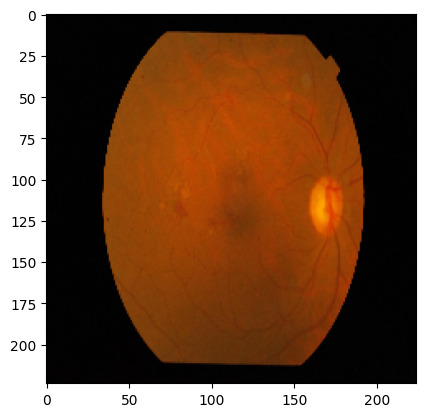

In [29]:
# Make predictions using the model
predictions = model.predict([unseen_images[:1], quantum_unseen[:1]])

# Print the predicted probabilities for each class
print("Predicted probabilities:")
print(predictions)

# Find the index of the class with the highest predicted probability for each example
predict_label = np.argmax(predictions, axis=1)

# Find the maximum predicted label value
max_predicted_label = np.max(predict_label)

print("Predicted labels:", predict_label)
print("Maximum predicted label:", max_predicted_label)

Actual={0:"Mild",1:"Moderate",2:"No_DR",3:"Proliferate_DR",4:"Severe"}
print("The class of the images is-->", Actual[max_predicted_label])

plt.imshow(display_image)

In [20]:
model.save('diabetic.keras')